In [1]:
!pip -q install tensorflow-datasets

import os, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# rock_paper_scissors has 2,892 labeled images of hands
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

print("Classes:", ds_info.features['label'].names)
num_classes = ds_info.features['label'].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.WPGHJ0_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.WPGHJ0_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Classes: ['rock', 'paper', 'scissors']


In [3]:
IMG_SIZE = 128  # keep small for speed

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Light augmentation for robustness
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.10),
])

def augment_fn(img, label):
    img = augment(img)
    return img, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train_prep = (ds_train
                 .shuffle(1000, reshuffle_each_iteration=True)
                 .map(preprocess, num_parallel_calls=AUTOTUNE)
                 .map(augment_fn, num_parallel_calls=AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTOTUNE))

ds_val_prep = (ds_test
               .map(preprocess, num_parallel_calls=AUTOTUNE)
               .batch(BATCH_SIZE)
               .prefetch(AUTOTUNE))


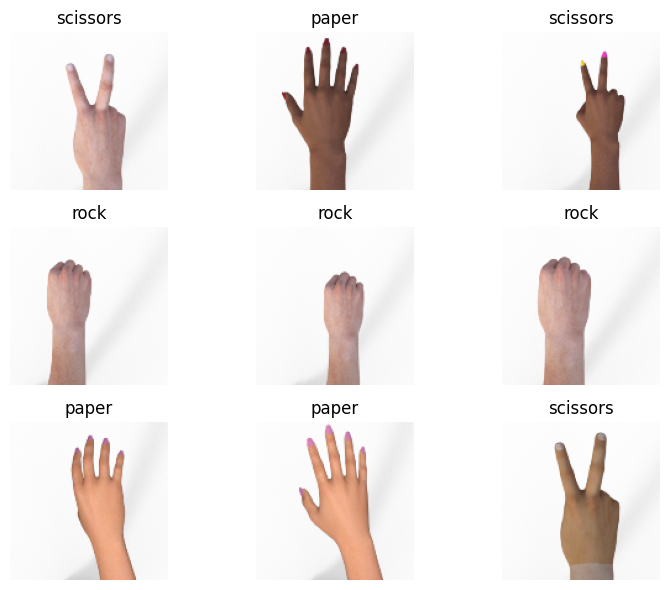

In [4]:
class_names = ds_info.features['label'].names

sample_batch = next(iter(ds_val_prep))
images, labels = sample_batch
plt.figure(figsize=(8,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'), layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, restore_best_weights=True)
]

history = model.fit(
    ds_train_prep,
    validation_data=ds_val_prep,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3884 - loss: 1.4326 - val_accuracy: 0.8118 - val_loss: 0.5583
Epoch 2/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8635 - loss: 0.3503 - val_accuracy: 0.8360 - val_loss: 0.3497
Epoch 3/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9525 - loss: 0.1377 - val_accuracy: 0.9220 - val_loss: 0.1788
Epoch 4/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9807 - loss: 0.0676 - val_accuracy: 0.9220 - val_loss: 0.2014
Epoch 5/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9866 - loss: 0.0568 - val_accuracy: 0.9113 - val_loss: 0.4123
Epoch 6/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9912 - loss: 0.0286 - val_accuracy: 0.9301 - val_loss: 0.1837
Epoch 7/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9859 - loss: 0.0449 - val_accuracy: 0.9247 - val_loss: 0.1473
Epoch 8/12
79/79 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9843 - loss: 0.0404 - val_accuracy: 0.9489 - val_loss

✅ Test Accuracy: 0.9624

📊 Classification Report:

              precision    recall  f1-score   support

        rock       1.00      0.99      1.00       124
       paper       0.99      0.90      0.94       124
    scissors       0.91      1.00      0.95       124

    accuracy                           0.96       372
   macro avg       0.97      0.96      0.96       372
weighted avg       0.97      0.96      0.96       372



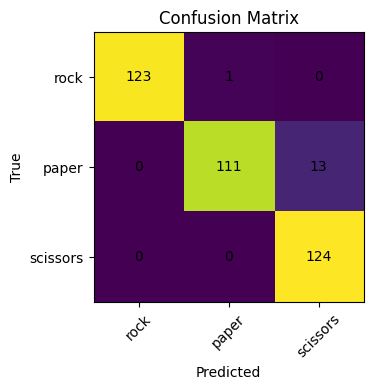

In [7]:
# Accuracy on test/val split
loss, acc = model.evaluate(ds_val_prep, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")

# Predictions for detailed report
y_true, y_pred = [], []
for batch_imgs, batch_labels in ds_val_prep:
    preds = model.predict(batch_imgs, verbose=0)
    y_true.extend(batch_labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()


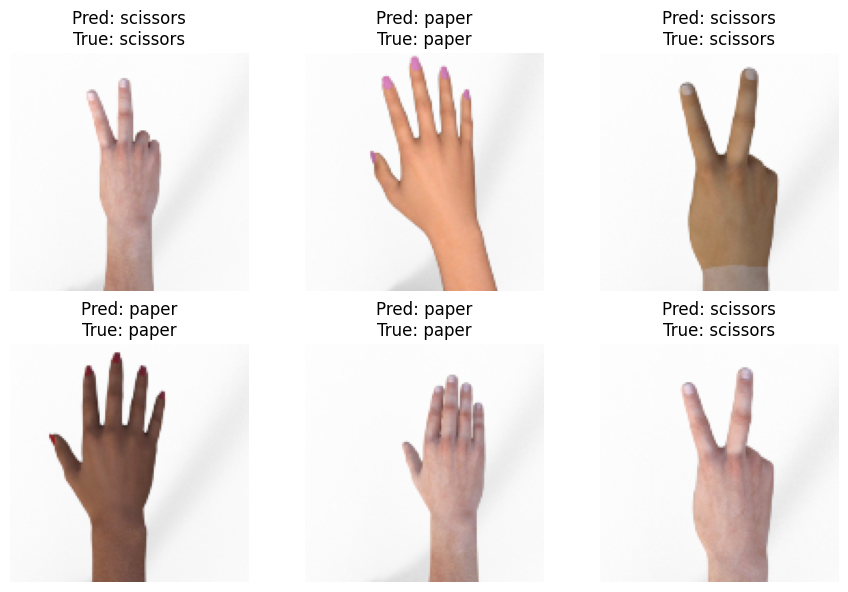

In [8]:
# Take 6 random images from the test set and show predictions
import random
sample_images, sample_labels = next(iter(ds_val_prep))
indices = random.sample(range(sample_images.shape[0]), k=6)

plt.figure(figsize=(9,6))
for i, idx in enumerate(indices):
    img = sample_images[idx:idx+1]
    pred = np.argmax(model.predict(img, verbose=0), axis=1)[0]
    true_label = int(sample_labels[idx].numpy())
    plt.subplot(2,3,i+1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true_label]}")
plt.tight_layout(); plt.show()


In [9]:
SAVE_DIR = "gesture_model"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, "rps_cnn.h5")
model.save(model_path)

# Save class names
with open(os.path.join(SAVE_DIR, "labels.txt"), "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("✅ Saved:", model_path)


✅ Saved: gesture_model/rps_cnn.h5


In [10]:
reloaded = tf.keras.models.load_model(model_path)

# Get one batch from val set and test
test_imgs, test_labels = next(iter(ds_val_prep))
preds = np.argmax(reloaded.predict(test_imgs[:8], verbose=0), axis=1)

print("Sample predictions:", [class_names[p] for p in preds])
print("Actual labels     :", [class_names[int(t)] for t in test_labels[:8].numpy()])


Sample predictions: ['scissors', 'paper', 'scissors', 'rock', 'rock', 'rock', 'paper', 'paper']
Actual labels     : ['scissors', 'paper', 'scissors', 'rock', 'rock', 'rock', 'paper', 'paper']


In [11]:
# Re-compile after loading to attach metrics (removes warning)
reloaded = tf.keras.models.load_model(model_path)
reloaded.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Now evaluate on validation set (optional, just to check)
val_loss, val_acc = reloaded.evaluate(ds_val_prep)
print(f"Validation accuracy: {val_acc:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.9711 - loss: 0.1927
Validation accuracy: 0.96


In [ ]:
+